# Part III: How to Secure Federated Learning in Network Monitoring

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leolavaur/icdcs_2024/blob/main/notebooks/part3.ipynb)

In this final part, we will see the security of a federated intrusion detection system. We will use the same dataset as in Part II, but we will now assume that an attacker is now sending malicious updates to negatively impact the system. We will see how the system can be made more robust to such attacks using a modified aggregation algorithm called FoolsGold.

## Section 0: Prerequisites

### Dependencies

> Be advised that Google collab currently does not support the latest versions of Python (limited to 3.10).
> However, some packages required in these notebooks require Python 3.11 or higher.
> Therefore, we recommend running these notebooks locally.

Let's start by obtaining our dataset.


In [1]:
# check if we are running on Google Colab
import os

from IPython.core.getipython import get_ipython

if not "google.colab" in str(get_ipython()):
    # cd to a temporary directory to avoid cluttering the current directory

    try:
        os.mkdir("/tmp/nslkdd")
    except FileExistsError:
        pass
    os.chdir("/tmp/nslkdd")

# download the dataset
if not os.path.exists("NSL-KDD/KDDTrain+.txt"):
    !curl -Lo nslkdd.zip "https://media.githubusercontent.com/media/leolavaur/icdcs_2024/main/nslkdd.zip?download=true"
    !unzip -o nslkdd.zip && rm nslkdd.zip

We can start by importing everything we need for this tutorial:

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import functools
import math
from collections import OrderedDict
from typing import Callable, cast

import flwr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from flwr.common import Metrics
from flwr.server.history import History
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
from numpy.typing import ArrayLike, NDArray
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

...and check that everything is working as expected. If you have access to a GPU, either on Colab on on your local machine, it should be detected and used by TensorFlow. We also use a Flower utility function to allow TensorFlow to share the GPU memory between multiple processes, which is necessary for running multiple clients in parallel.

In [3]:
print("TensorFlow version:", tf.__version__)
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
enable_tf_gpu_growth()

TensorFlow version: 2.17.0
Num GPUs Available: 1


To allow others to reproduce your results with certitude, set a seed for all the pseudo-random number generators (PRNG) that you use. You should also run your threads deterministically, in case your ML backend optimize training. This will have a negative impact on the performance. On TensorFlow: 

In [4]:
def set_seed(seed: int):
    keras.utils.set_random_seed(SEED)
    tf.config.experimental.enable_op_determinism()


SEED = 1138
set_seed(SEED)

## Section 1: Dataset and model setup

This part is the same as in Part II. We will use the same dataset, and we will split it into a training set and a test set. We will also split the training set into multiple clients, and we will use the same partitioning as in Part II. We will also reuse our model from Part II.

In [5]:
BATCH_SIZE = 128
EPOCHS = 1
NUM_CLIENTS = 10
NUM_ROUNDS = 10

In [6]:
def load_nslkdd() -> (
    tuple[
        tuple[pd.DataFrame, pd.DataFrame, pd.Series],
        tuple[pd.DataFrame, pd.DataFrame, pd.Series],
    ]
):
    # column names:
    # https://github.com/kahramankostas/NSL-KDD-binary-classification-with-Transformer#reading-csv-files
    c_names = [
        "duration",
        "protocol_type",
        "service",
        "flag",
        "src_bytes",
        "dst_bytes",
        "land",
        "wrong_fragment",
        "urgent",
        "hot",
        "num_failed_logins",
        "logged_in",
        "num_compromised",
        "root_shell",
        "su_attempted",
        "num_root",
        "num_file_creations",
        "num_shells",
        "num_access_files",
        "num_outbound_cmds",
        "is_host_login",
        "is_guest_login",
        "count",
        "srv_count",
        "serror_rate",
        "srv_serror_rate",
        "rerror_rate",
        "srv_rerror_rate",
        "same_srv_rate",
        "diff_srv_rate",
        "srv_diff_host_rate",
        "dst_host_count",
        "dst_host_srv_count",
        "dst_host_same_srv_rate",
        "dst_host_diff_srv_rate",
        "dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate",
        "dst_host_srv_serror_rate",
        "dst_host_rerror_rate",
        "dst_host_srv_rerror_rate",
        "label",
        "difficulty",
    ]

    # load datasets
    train_df = pd.read_csv("./NSL-KDD/KDDTrain+.txt", names=c_names)
    test_df = pd.read_csv("./NSL-KDD/KDDTest+.txt", names=c_names)

    # extract the labels for the outputs (will serve as metadata)
    m_train = train_df["label"]
    m_test = test_df["label"]

    # drop labels for input, and difficulty
    train_df = train_df.drop(columns=["label", "difficulty"])
    test_df = test_df.drop(columns=["label", "difficulty"])

    # convert classes to numerical values
    X_train = pd.get_dummies(train_df)
    X_test = pd.get_dummies(test_df)

    # reindex the testing dataset so its columns match the training columns
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # normalize input dataframes
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train[X_train.columns] = scaler.transform(X_train)
    X_test[X_test.columns] = scaler.transform(X_test)

    # transform outputs to binary classification
    y_train = m_train.apply(lambda x: False if x == "normal" else True)
    y_test = m_test.apply(lambda x: False if x == "normal" else True)

    # apply one-hot encoding to outputs
    y_train = pd.get_dummies(y_train, prefix="Malicious")
    y_test = pd.get_dummies(y_test, prefix="Malicious")

    return (X_train, y_train, m_train), (X_test, y_test, m_test)

In [7]:
(X_train, y_train, m_train), (X_test, y_test, m_test) = load_nslkdd()
ATTACK_LABELS = m_train.unique()[m_train.unique() != "normal"]

In [8]:
n_features = X_train.shape[1]
print(n_features)


def mk_model() -> keras.Model:
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Dense(64, activation="relu", input_shape=(n_features,)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(2, activation="softmax"),
        ]
    )

    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"],
        # run_eagerly=True,  # test due to the bug in ray
    )
    return model


mk_model().summary()

122


/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,162 (47.51 KB)

 Trainable params: 12,162 (47.51 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Only keep attacks that are well detected
# (d["rate"] > 0.5) & (d["count"] > 100)
DROPABLE_CLASSES = [
    "neptune",
    "normal",
    "saint",
    "mscan",
    "smurf",
    "satan",
    "ipsweep",
    "portsweep",
]


def partition(
    num_shards: int,
    dataset: tuple[pd.DataFrame, pd.DataFrame, pd.Series],
    n_drop: int = 0,
) -> list[tuple[pd.DataFrame, pd.DataFrame, pd.Series]]:
    """Partition the NSL-KDD dataset."""
    X, y, m = dataset
    partitions = []
    # We keep all partitions equal-sized in this example
    partition_size = math.floor(len(X) / num_shards)
    shuffle_idx = np.random.permutation(len(X))
    X, y, m = X.iloc[shuffle_idx], y.iloc[shuffle_idx], m.iloc[shuffle_idx]

    for i in range(num_shards):
        idx_from, idx_to = i * partition_size, (i + 1) * partition_size

        X_part = X[idx_from:idx_to]
        y_part = y[idx_from:idx_to]
        m_part = m[idx_from:idx_to]

        # randomly remove NUM_REMOVED_CLASSES from each partition
        _rm_classes = np.random.choice(DROPABLE_CLASSES, n_drop, replace=False)

        X_part = X_part[m_part.isin(_rm_classes) == False]
        y_part = y_part[m_part.isin(_rm_classes) == False]
        m_part = m_part[m_part.isin(_rm_classes) == False]

        partitions.append((X_part, y_part, m_part))
    return partitions

In [10]:
def get_evaluate_fn(testset):
    """Return an evaluation function for server-side (i.e. centralized) evaluation."""
    x_test, y_test, _ = testset

    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: flwr.common.NDArrays,
        config: dict[str, flwr.common.Scalar],
    ):
        if server_round == NUM_ROUNDS:
            # Save final model

            np.save("fl_weights", np.array(parameters, dtype=object))

        model = mk_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, _ = model.evaluate(x_test, y_test, verbose=cast(str, 0))

        inferences = model.predict(x_test, verbose=cast(str, 0))
        y_pred = np.argmax(np.round(inferences), axis=1)
        y_true = np.argmax(y_test.to_numpy(), axis=1)

        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        return (
            loss,
            {
                "accuracy": (tn + tp) / (tn + fp + fn + tp),
                "precision": tp / (tp + fp),
                "recall": tp / (tp + fn),
                "f1": 2 * tp / (2 * tp + fp + fn),
                "miss_rate": fn / (fn + tp),
            },
        )

    return evaluate

In [11]:
class FlowerClient(flwr.client.NumPyClient):
    def __init__(self, X, y):
        self.X_train = X
        self.y_train = y

        self.model = mk_model()

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(
            self.X_train,
            self.y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.1,
            verbose=cast(str, 0),
        )
        return self.model.get_weights(), len(self.X_train), {}

In [12]:
from flwr.client import Client


def mk_client_fn(partitions):
    """Return a function which creates a new FlowerClient for a given partition."""

    def client_fn(cid: str) -> Client:
        """Create a new FlowerClient for partition i."""
        x_train, y_train, _ = partitions[int(cid)]

        return FlowerClient(x_train, y_train).to_client()

    return client_fn

In addition to what is done in part I, we will add a function to automate the FL process, as we will have multiple experiments to run in this part.

In [13]:
from flwr.common import ndarrays_to_parameters


def init_fn():
    set_seed(SEED)
    enable_tf_gpu_growth()


def fl(
    partitions,
    testset,
    num_clients=NUM_CLIENTS,
    num_rounds=NUM_ROUNDS,
    strategy_class=flwr.server.strategy.FedAvg,
) -> History:
    # Create dataset partitions (needed if your dataset is not pre-partitioned)

    # Create FedAvg strategy
    strategy = strategy_class(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=0.0,  # Disable the federated evaluation
        min_fit_clients=NUM_CLIENTS,  # Always sample all clients
        min_available_clients=NUM_CLIENTS,
        evaluate_fn=get_evaluate_fn(testset),  # global evaluation function
        initial_parameters=ndarrays_to_parameters(mk_model().get_weights()),
    )

    # With a dictionary, you tell Flower's VirtualClientEngine that each
    # client needs exclusive access to these many resources in order to run
    client_resources = {
        "num_cpus": max(int((os.cpu_count() or 1) / num_clients), 1),
        "num_gpus": 0.0,
    }

    # Start simulation
    return flwr.simulation.start_simulation(
        client_fn=mk_client_fn(partitions),
        num_clients=num_clients,
        config=flwr.server.ServerConfig(num_rounds=num_rounds),
        strategy=strategy,
        client_resources=client_resources,
        actor_kwargs={
            "on_actor_init_fn": init_fn  # Enable GPU growth upon actor init.
        },
        ray_init_args={"num_gpus": len(tf.config.list_physical_devices("GPU"))},
    )

Note that the different partitions have different sizes since we are using a non-stratified NIID partitioning. Clients are therefore different in terms of both, the number of samples they have and the distribution of classes in their data.

In [14]:
trainset, testset = load_nslkdd()

partitions = partition(NUM_CLIENTS, trainset, 4)
for p in partitions:
    print(len(p[0]))

1407
4961
8098
7822
8190
1363
7857
5273
5257
7498


Finall, we will re-run the training process from Part II to make sure that everything is working as expected, and gather the results.

In [15]:
history_baseline = fl(partitions, testset)
fl_weights = np.load("fl_weights.npy", allow_pickle=True)

/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-23 11:13:12,831	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'memory': 7853940736.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 a

In [16]:
def eval_model(parameters, testset):
    loss, metrics = get_evaluate_fn(testset)(0, parameters, {})
    return {"loss": loss} | metrics


def eval_classes(parameters, testset, classes=None):
    X, y, m = testset
    if classes is None:
        classes = m.unique()
    model = mk_model()
    model.set_weights(parameters)
    inferences = model.predict(X)
    y_pred = np.argmax(np.round(inferences), axis=1)
    y_true = np.argmax(y.to_numpy(), axis=1)

    classes_stats = {}
    for cls in classes:
        class_filter = m == cls

        count = len(m[class_filter])
        if not (count > 0):
            continue
        correct = len(m[(class_filter) & (y_true == y_pred)])
        missed = len(m[(class_filter) & (y_true != y_pred)])

        classes_stats[cls] = {
            "count": count,
            "correct": correct,
            "missed": missed,
            "rate": correct / count,
        }

    ret = pd.DataFrame(classes_stats).T
    ret[["count", "correct", "missed"]].astype(int, copy=False)
    return ret

In [17]:
eval_model(fl_weights, testset)

/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


{'loss': 0.6972843408584595,
 'accuracy': 0.7931156848828956,
 'precision': 0.9144596651445966,
 'recall': 0.7022520065456246,
 'f1': 0.7944287729196051,
 'miss_rate': 0.2977479934543754}

In [18]:
eval_classes(fl_weights, testset)

 53/705 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step

/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step


,count,correct,missed,rate
neptune,4657.0,4657.0,0.0,1.000000
normal,9711.0,8868.0,843.0,0.913191
saint,319.0,308.0,11.0,0.965517
mscan,996.0,938.0,58.0,0.941767
guess_passwd,1231.0,22.0,1209.0,0.017872
smurf,665.0,665.0,0.0,1.000000
apache2,737.0,486.0,251.0,0.659430
satan,735.0,683.0,52.0,0.929252
buffer_overflow,20.0,2.0,18.0,0.100000
back,359.0,47.0,312.0,0.130919


## Section 2: The impact of poisoning

Let's build a poisoning function. This one is quite versatile so you can try the different types of attacks, such as targeted (also called backdoors attacks) or untargeted ones. This function will be reused for the next examples.

In [19]:
def poison(
    shard: tuple[pd.DataFrame, pd.DataFrame, pd.Series], target: list[str]
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    """Poison the given shard by flipping the labels of the given target.

    If target is empty, all samples are poisoned.
    If target is "*", all malicious samples are poisoned.
    Otherwise, only the specified targets are poisoned.

    Parameters
    ----------
    shard
        The dataset shard to poison.
    target
        A list of classes to target in the given dataset.

    """
    X, y, m = shard
    X = X.copy()
    y = y.copy()
    m = m.copy()

    if len(target) == 0:
        # if no target is specified, poison all samples (i.e. flip benign/malicious)
        y = y.apply(
            lambda x: (1, 0) if tuple(x) == (0, 1) else (0, 1),
            axis=1,
            result_type="broadcast",
        )
        # else, if "*", poison all malicious samples, effectively backdoring all attacks
    elif len(target) == 1 and target == ["*"]:
        y = y.apply(lambda x: (1, 0), axis=1, result_type="broadcast")
    else:
        # otherwise, poison only the specified targets (i.e. mark samples as benign)
        mask = m.isin(target)
        idx = y[mask].index  # .to_list()

        y.loc[idx] = y.loc[idx].apply(lambda x: (1, 0), axis=1, result_type="broadcast")

    return X, y, m

### 2.1 Testing poisoning locally

Let's validate the impact our poisoning function locally. We will instantiate a participant with a IID shard to see the impact of the poisoning function. We will compare the results of two clients, one with a clean dataset and one with a poisoned dataset.

In [20]:
partitions = partition(NUM_CLIENTS, trainset)
X, y, m = partitions[0]

In [21]:
client = FlowerClient(X, y)
m = mk_model()
w, _, _ = client.fit(m.get_weights(), {})

eval_model(w, testset)

/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


{'loss': 0.6934630870819092,
 'accuracy': 0.7615773598296665,
 'precision': 0.9185185185185185,
 'recall': 0.637730850151952,
 'f1': 0.7527940026675252,
 'miss_rate': 0.362269149848048}

In [22]:
eval_classes(w, testset)

 47/705 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,count,correct,missed,rate
neptune,4657.0,4656.0,1.0,0.999785
normal,9711.0,8985.0,726.0,0.925239
saint,319.0,307.0,12.0,0.962382
mscan,996.0,938.0,58.0,0.941767
guess_passwd,1231.0,12.0,1219.0,0.009748
smurf,665.0,665.0,0.0,1.000000
apache2,737.0,196.0,541.0,0.265943
satan,735.0,709.0,26.0,0.964626
buffer_overflow,20.0,0.0,20.0,0.000000
back,359.0,0.0,359.0,0.000000


In [23]:
partitions = partition(NUM_CLIENTS, trainset)
x_poison, y_poison, m_poison = poison(partitions[0], ["portsweep"])

In [24]:
client = FlowerClient(x_poison, y_poison)
m = mk_model()
w, _, _ = client.fit(m.get_weights(), {})

eval_model(w, testset)

/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


{'loss': 0.6982178688049316,
 'accuracy': 0.7460965223562811,
 'precision': 0.9512504760695696,
 'recall': 0.5838852957219668,
 'f1': 0.7236117817479478,
 'miss_rate': 0.4161147042780332}

In [25]:
eval_classes(w, testset)

  1/705 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step

/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,count,correct,missed,rate
neptune,4657.0,4646.0,11.0,0.997638
normal,9711.0,9327.0,384.0,0.960457
saint,319.0,305.0,14.0,0.956113
mscan,996.0,495.0,501.0,0.496988
guess_passwd,1231.0,11.0,1220.0,0.008936
smurf,665.0,665.0,0.0,1.000000
apache2,737.0,149.0,588.0,0.202171
satan,735.0,635.0,100.0,0.863946
buffer_overflow,20.0,0.0,20.0,0.000000
back,359.0,0.0,359.0,0.000000


### 2.2 Sybil attack on the FL model

In [26]:
NUM_CLIENTS = 10
NUM_ATTACKERS = 6
TARGET = []

partitions = partition(NUM_CLIENTS + 1, trainset, 5)
benign_partitions = partitions[:NUM_CLIENTS]
malicious_part = partitions[-1]

# poison the attacker partition
x_poison, y_poison, m_poison = poison(malicious_part, TARGET)

partitions = benign_partitions + [(x_poison, y_poison, m_poison)] * NUM_ATTACKERS

In [27]:
history_poisoned = fl(partitions, testset, num_clients=NUM_CLIENTS + NUM_ATTACKERS)

/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-23 11:15:39,554	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'memory': 8761842074.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 a

In [28]:
weights = np.load("fl_weights.npy", allow_pickle=True)

In [29]:
eval_model(weights, testset)

/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


{'loss': 2.4333908557891846,
 'accuracy': 0.5685770049680624,
 'precision': 0.9974383605507525,
 'recall': 0.24273357749551935,
 'f1': 0.390448734018551,
 'miss_rate': 0.7572664225044806}

In [30]:
eval_classes(weights, testset)

 54/705 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step

/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,count,correct,missed,rate
neptune,4657.0,3031.0,1626.0,0.650848
normal,9711.0,9703.0,8.0,0.999176
saint,319.0,4.0,315.0,0.012539
mscan,996.0,0.0,996.0,0.000000
guess_passwd,1231.0,0.0,1231.0,0.000000
smurf,665.0,0.0,665.0,0.000000
apache2,737.0,0.0,737.0,0.000000
satan,735.0,5.0,730.0,0.006803
buffer_overflow,20.0,0.0,20.0,0.000000
back,359.0,0.0,359.0,0.000000


## Section 3: Protecting against sybils -- FoolsGold

FoolsGold is a modified version of the FedAvg algorithm that is robust to sybil attacks. It is based on the idea that sybils will have a different gradient than honest clients, and that we can detect them by looking at the gradient distribution. 

FoolsGold works on the assumption that sybils are orchestrated by a single attacker, and therefore have similar gradient updates.

![FoolsGold](image.png)

In [31]:
from typing import Optional, Union

import sklearn.metrics.pairwise as smp
from flwr.common import (
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import FedAvg
from flwr.server.strategy.aggregate import aggregate


def foolsgold(grads: NDArray) -> NDArray:
    """FoolsGold algorithm.

    The content of this function is based on the original implementation of FoolsGold
    devilvered by the authors of the paper. The function is only slightly modified to
    provide explicit typing annotations.

    Link to FoolsGold's repository:
    https://github.com/DistributedML/FoolsGold/blob/master/deep-fg/fg/foolsgold.py

    Parameters
    ----------
        grads (NDArray): A list of historically aggregated gradients, each gradient
            being a list of layers as numpy arrays. Unlike in the original
            implementation, gradients here are the difference between w_i^r and
            w_0^{r-1}, not the gradients themselves.

    Returns
    -------
        A list of weights, one for each client. The sum of the weights must be 1.

    """
    n_clients = grads.shape[0]
    cs: NDArray = smp.cosine_similarity(grads) - np.eye(n_clients)
    maxcs: NDArray = np.max(cs, axis=1)
    # pardoning
    for i in range(n_clients):
        for j in range(n_clients):
            if i == j:
                continue
            if maxcs[i] < maxcs[j]:
                cs[i][j] = cs[i][j] * maxcs[i] / maxcs[j]
    wv: NDArray = 1 - (np.max(cs, axis=1))
    wv[wv > 1] = 1
    wv[wv < 0] = 0

    # Rescale so that max value is wv
    wv = wv / np.max(wv)
    wv[(wv == 1)] = 0.99

    # Logit function
    wv = np.log(wv / (1 - wv)) + 0.5
    wv[(np.isinf(wv) + wv > 1)] = 1
    wv[(wv < 0)] = 0

    return wv


def flatten_model(model: list[NDArray]) -> NDArray:
    """Flatten the model into a 1D array.

    Arguments:
    ---------
        model: A list of numpy arrays.

    Returns:
    -------
        The flattened model.

    """
    return np.concatenate([layer.ravel() for layer in model])


class FoolsGold(FedAvg):
    def __init__(self, *args, **kwargs) -> None:
        """Initialize simulation strategy."""
        assert "initial_parameters" in kwargs, "initial_parameters must be provided"
        # Each client has a history of its flattened gradients at each round
        self.history: dict[str, NDArray] = {}
        self.global_model = parameters_to_ndarrays(kwargs["initial_parameters"])

        super().__init__(*args, **kwargs)

    def aggregate_fit(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, FitRes]],
        failures: list[Union[tuple[ClientProxy, FitRes], BaseException]],
    ) -> tuple[Optional[Parameters], dict[str, Scalar]]:
        """Aggregate fit using FoolsGold algorithm.

        FoolsGold

        Arguments:
        ---------
            server_round: The current round of the server.
            results: A list of tuples containing the client and the result of
                the fit operation.
            failures: A list of tuples containing the client and the result of
                the fit operation or the exception raised during the fit
                operation.

        Returns:
        -------
            A tuple containing the aggregated parameters and the metrics.

        """
        # Call super method to save client states
        _, _ = super().aggregate_fit(server_round, results, failures)

        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Get results and sort them by client ids
        client_results = [
            (
                proxy.cid,
                parameters_to_ndarrays(fit_res.parameters),
                fit_res.num_examples,
            )
            for proxy, fit_res in results
        ]
        client_results.sort(key=lambda x: x[0])

        # Update history
        for cid, m, _ in client_results:
            grads = flatten_model(m) - flatten_model(self.global_model)
            if cid not in self.history:
                self.history[cid] = np.zeros_like(grads)
            self.history[cid] += grads

        # Get a NDArray of shape (num_clients, num_parameters) with flattened models
        model_updates = np.array(
            [g for _, g in sorted(self.history.items(), key=lambda x: x[0])]
        )

        weights = foolsgold(model_updates)

        weights_results = [(p, w) for (_, p, _), w in zip(client_results, weights)]

        agg = aggregate(weights_results)
        self.global_model = agg

        parameters_aggregated = ndarrays_to_parameters(agg)

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)

        return parameters_aggregated, metrics_aggregated

In [32]:
history_fg = fl(partitions, testset, strategy_class=FoolsGold)

/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-23 11:18:36,051	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 8865621607.0, 'GPU': 1.0, 'object_store_memory': 2147483648.0, 'node:__internal_head__': 1.0, 'node:127.0.0.1': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 a

In [33]:
weights = np.load("fl_weights.npy", allow_pickle=True)

In [34]:
eval_model(weights, testset)

/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


{'loss': 0.5900793671607971,
 'accuracy': 0.8270936834634492,
 'precision': 0.9188935771214253,
 'recall': 0.7636561988623081,
 'f1': 0.8341135415780067,
 'miss_rate': 0.23634380113769188}

In [35]:
eval_classes(weights, testset)

 52/705 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step

/Users/leo/Workspace/phdcybersec/icdcs_2024/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step


,count,correct,missed,rate
neptune,4657.0,4657.0,0.0,1.000000
normal,9711.0,8846.0,865.0,0.910926
saint,319.0,309.0,10.0,0.968652
mscan,996.0,934.0,62.0,0.937751
guess_passwd,1231.0,116.0,1115.0,0.094232
smurf,665.0,665.0,0.0,1.000000
apache2,737.0,728.0,9.0,0.987788
satan,735.0,667.0,68.0,0.907483
buffer_overflow,20.0,3.0,17.0,0.150000
back,359.0,45.0,314.0,0.125348


Text(0.5, 1.0, 'Baseline vs. Poisoned vs. Foolsgold \n 10 clients with 10 clients per round')

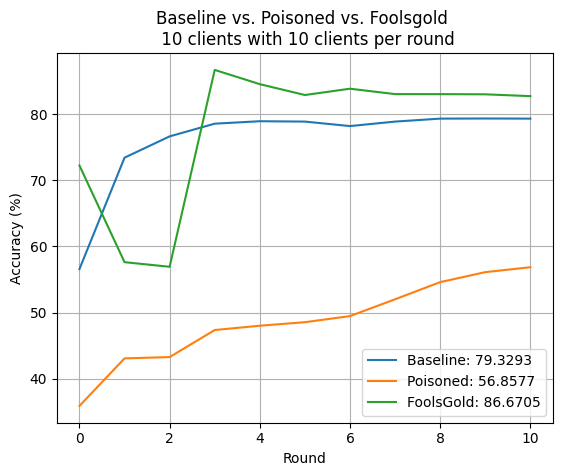

In [36]:
baseline_metrics = cast(list, history_baseline.metrics_centralized["accuracy"])
round = [data[0] for data in baseline_metrics]
acc_baseline = [100.0 * data[1] for data in baseline_metrics]

plt.plot(round, acc_baseline, label=f"Baseline: {max(acc_baseline):.4f}")

poisoned_metrics = cast(list, history_poisoned.metrics_centralized["accuracy"])
acc_poisoned = [100.0 * data[1] for data in poisoned_metrics]

plt.plot(round, acc_poisoned, label=f"Poisoned: {max(acc_poisoned):.4f}")

fg_metrics = cast(list, history_fg.metrics_centralized["accuracy"])
acc_fg = [100.0 * data[1] for data in fg_metrics]

plt.plot(round, acc_fg, label=f"FoolsGold: {max(acc_fg):.4f}")

plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.legend()
plt.title("Baseline vs. Poisoned vs. Foolsgold \n 10 clients with 10 clients per round")